# RNN Kullanılarak Bir Günlük Hava Sıcaklık Tahmini
----------------------------
# Jena Climate 2009-2016 Dataset

# Dataset'in Çekilmesi ve İnceleme

In [1]:
# Dosya okuma işlemleri için gerekli kütüphanelerin import edilmesi
import os

In [2]:
# Dataset'in kayıtlı olduğu cvs dosyasının yolu
data_dir = 'C:\\Users\\oguzs\\ColabCodes\\Datasets\\Jena_Climate_2009_2016'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [3]:
# Verilerin dosyadan okunması
f = open(fname)
data = f.read()
f.close()

In [4]:
# Verilerle feature name'lerin birbirinden ayrılması
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [5]:
# feature name ve toplam veri sayısının gösterimi
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [6]:
# Numpy array'leri ile çalışabilmek için gerekli kütüphanelerin import edilmesi
import numpy as np

In [7]:
# Verilerin feature'lara göre parçalanması
float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [8]:
# Veriyi incelemek ve eğitimi görselleştirmek için gerekli kütüphanenin import edilmesi
from matplotlib import pyplot as plt

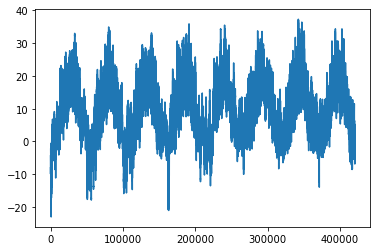

In [9]:
# Tüm veri
# (Veriler 10 dakikada bir kaydedilmiştir...)
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

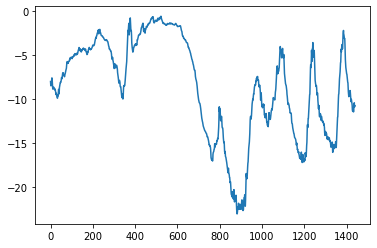

In [10]:
# Bir günlük veri
plt.plot(range(1440), temp[:1440])

# Verilerin Normalizesi, Üreteçler ve Modelin Oluşturulması

In [11]:
# Verilerin normalize edilmesi
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [12]:
# Geçmiş verileri samples (x -> girdi) ve ileri zamanki verileri targets (y -> çıktı) olarak
# gruplar halinde geri döndüren üretecin fonksiyonu
# 
# data -> Gelen veri
# lookback -> Kaç zaman adımı geriye bakılacağı
# delay -> Hedefin kaç zaman adımı sonrası olacağı
# min_index -> train, validation ve test verilerinin sınırlarının belirlenebilmesi için min değer
# max_index -> train, validation ve test verilerinin sınırlarının belirlenebilmesi için max değer
# shuffle -> Verilerde karılma olup olmayacağı
# batch_size -> Yığındaki örnek sayısı
# step -> Kaç zaman adımında bir örnekleme yapılacağı
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    
    if max_index is None:
        max_index = len(data) - delay - 1
        
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

In [13]:
# Parametrelerin ayarlanması ve üreteçlerin oluşturulması
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [14]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

In [15]:
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

In [16]:
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [17]:
# Validation ve test verilerindeki toplam adım
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [18]:
# Kayıp Akıl yürütme modeli kullanılarak kayıp ölçülmesi
# (Zaman serisindeki yakın verilerinbirbirine benzer olmasından dolayı kullanılan baz model)
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [19]:
evaluate_naive_method()

0.2897359729905486


In [14]:
# Model için gerekli kütüphanelerin import edilmesi
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [22]:
# İlk tasarlanan temel model
# (fonksiyonun oluşturulması, çağrılması ve compile edilmesi)
def myModel():
    model = Sequential()
    
    model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    
    return model

In [23]:
model = myModel()

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Modelin compile edilmesi
# (Mean Absolute Error -> mae)
model.compile(optimizer=RMSprop(), loss='mae')

# Eğitme ve Başarımı Değerlendirme

In [26]:
# Modelin eğitilmesi
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 9s 17ms/step - loss: 1.4506 - val_loss: 0.7018
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.4673 - val_loss: 0.3334
Epoch 3/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2942 - val_loss: 0.3529
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2686 - val_loss: 0.2661
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2548 - val_loss: 0.2700
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2439 - val_loss: 0.2679
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2380 - val_loss: 0.2656
Epoch 8/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2309 - val_loss: 0.5449
Epoch 9/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2257 - val_loss: 0.3870
Epoch 10/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2222 - val_l

In [15]:
# Loss grafini çizdiren fonksiyon
def showLoss(arg_history):
    
    loss = arg_history.history['loss']
    val_loss = arg_history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label='Eğitim Kaybı')
    plt.plot(epochs, val_loss, 'b', label='Doğrulama Kaybı')
    plt.title('Eğitim ve Doğrulama Kaybı')
    plt.legend()
    
    plt.show()

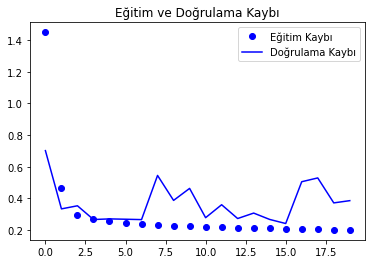

In [29]:
# Loss grafiğinin çizdirilmesi
showLoss(history)

# RNN'li İlk Basit Model

In [30]:
# GRU katmanının kullanıldığı RNN'li model
# (Gated Recurrent Unit -> GRU)
def myModel2():
    model = Sequential()
    
    model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
    model.add(layers.Dense(1))
    
    return model

In [31]:
model = myModel2()

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer=RMSprop(), loss='mae')

# Eğitme ve Başarımı Değerlendirme 2

In [34]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 160s 320ms/step - loss: 0.3031 - val_loss: 0.3166
Epoch 2/20
500/500 [==============================] - 163s 326ms/step - loss: 0.2825 - val_loss: 0.3364
Epoch 3/20
500/500 [==============================] - 161s 323ms/step - loss: 0.2743 - val_loss: 0.3417
Epoch 4/20
500/500 [==============================] - 165s 331ms/step - loss: 0.2716 - val_loss: 0.3624
Epoch 5/20
500/500 [==============================] - 164s 327ms/step - loss: 0.2673 - val_loss: 0.3682
Epoch 6/20
500/500 [==============================] - 161s 322ms/step - loss: 0.2661 - val_loss: 0.3693
Epoch 7/20
500/500 [==============================] - 161s 323ms/step - loss: 0.2621 - val_loss: 0.3225
Epoch 8/20
500/500 [==============================] - 162s 324ms/step - loss: 0.2596 - val_loss: 0.3158
Epoch 9/20
500/500 [==============================] - 162s 324ms/step - loss: 0.2541 - val_loss: 0.3096
Epoch 10/20
500/500 [==============================] - 162s 324m

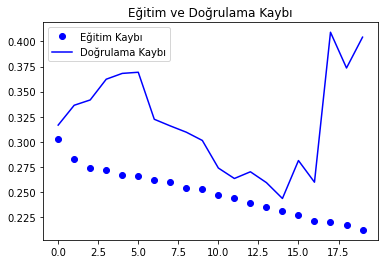

In [35]:
showLoss(history)

# Seyreltmeli RNN Model

In [22]:
# Overfitting'i emgellemek için seyreltme (dropout, recurrent_dropout) kullanılan model
def myModel3():
    model = Sequential()
    
    model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
    model.add(layers.Dense(1))
    
    return model

In [23]:
model = myModel3()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                4608      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer=RMSprop(), loss='mae')

# Eğitme ve Başarımı Değerlendirme 3

In [26]:
# (Seyreltme uygulandığından epoch iki katına çıkarıldı.)
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/40
500/500 [==============================] - 268s 535ms/step - loss: 0.3284 - val_loss: 0.2765
Epoch 2/40
500/500 [==============================] - 267s 535ms/step - loss: 0.3092 - val_loss: 0.2723
Epoch 3/40
500/500 [==============================] - 284s 568ms/step - loss: 0.3040 - val_loss: 0.2703
Epoch 4/40
500/500 [==============================] - 274s 548ms/step - loss: 0.3022 - val_loss: 0.2691
Epoch 5/40
500/500 [==============================] - 274s 548ms/step - loss: 0.3003 - val_loss: 0.2704
Epoch 6/40
500/500 [==============================] - 263s 527ms/step - loss: 0.2949 - val_loss: 0.2666
Epoch 7/40
500/500 [==============================] - 263s 526ms/step - loss: 0.2946 - val_loss: 0.2652
Epoch 8/40
500/500 [==============================] - 261s 521ms/step - loss: 0.2916 - val_loss: 0.265

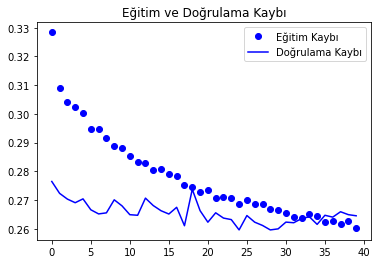

In [27]:
showLoss(history)

# CNN + RNN'li Model

In [16]:
# CNN'in örüntü öğrenme ve RNN'in zamansal ilişki kurabilme özelliği birleştiriliyor.
# (Saatte 1 örnekten yarım saatte 1 örneğe çekildi. Üreteçler güncelleniyor.)
lookback = 720
step = 3

In [17]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)

In [18]:
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)

In [19]:
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)

In [20]:
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [21]:
# CNN + RNN modeli
def myModel4():
    model = Sequential()
    
    model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
    model.add(layers.MaxPooling1D(3))
    model.add(layers.Conv1D(32, 5, activation='relu'))
    
    model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
    model.add(layers.Dense(1))
    
    return model

In [22]:
model = myModel4()

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer=RMSprop(), loss='mae')

# Eğitme ve Başarımı Değerlendirme 4

In [25]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 775 steps
Epoch 1/20
500/500 [==============================] - 99s 198ms/step - loss: 0.3375 - val_loss: 0.2878
Epoch 2/20
500/500 [==============================] - 93s 187ms/step - loss: 0.3034 - val_loss: 0.2789
Epoch 3/20
500/500 [==============================] - 94s 188ms/step - loss: 0.2937 - val_loss: 0.2796
Epoch 4/20
500/500 [==============================] - 95s 189ms/step - loss: 0.2841 - val_loss: 0.2694
Epoch 5/20
500/500 [==============================] - 96s 193ms/step - loss: 0.2771 - val_loss: 0.2667
Epoch 6/20
500/500 [==============================] - 96s 193ms/step - loss: 0.2725 - val_loss: 0.2709
Epoch 7/20
500/500 [==============================] - 97s 193ms/step - loss: 0.2653 - val_loss: 0.2832
Epoch 8/20
500/500 [==============================] - 97s 195ms/step - loss: 0.2588 - val_loss: 0.2742
Epoch 

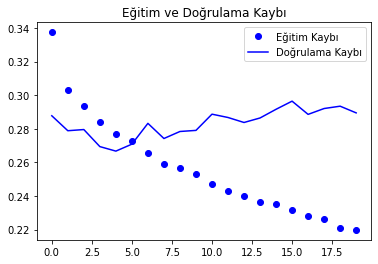

In [26]:
showLoss(history)

In [27]:
# Model kaybının test verisiyle ölçümü
test_loss = model.evaluate_generator(test_gen, steps=test_steps)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


In [28]:
print('test loss: ', test_loss)

test loss:  0.3009592951539366
